In [1]:
%matplotlib inline

from os.path import join
import os

import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from net_serialization import save_pytorch_data, load_pytorch_data

In [2]:
torchvision.__version__

'0.11.1+cu102'

In [3]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [4]:
class Image_Convolution_Transformation_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 1024, 4, 1)
        self.conv2 = nn.Conv2d(1024, 512, 8, 1)
        self.conv3 = nn.Conv2d(512, 256, 16, 1)
        self.conv4 = nn.Conv2d(256, 128, 32, 1)
        self.conv5 = nn.Conv2d(128, 3, 64, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x

In [19]:
class Image_Convolution_Transformation_Net_Small(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 4, 1)
        self.conv2 = nn.Conv2d(256, 128, 32, 1)
        self.conv3 = nn.Conv2d(128, 3, 64, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        return x

In [6]:
def load_image(img_path, max_size, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max(image.size)
    if size > max_size:
        size = max_size
        
    if shape is not None:
        size = shape
    
    img_transformations = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                            ])
    
    image = img_transformations(image).unsqueeze(0)
    
    return image

In [7]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [27]:
content = load_image(join('my_photos', 'IMG_6520.jpg'), 400).to(device)
style = load_image(join('images', 'MonaLisa.jpg'), 400, shape=content.shape[-2:]).to(device)

In [28]:
#content = load_image(join('Images', 'City.jpg'), 400).to(device)
#style = load_image(join('Images', 'StarryNight.jpg'), 400, shape=content.shape[-2:]).to(device)

(-0.5, 599.5, 399.5, -0.5)

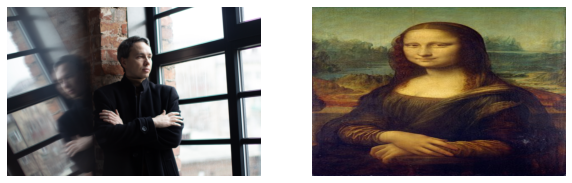

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.imshow(img_convert(content))
ax1.axis('off')
ax2.imshow(img_convert(style))
ax2.axis('off')

In [20]:
net = Image_Convolution_Transformation_Net_Small()
#net = Image_Convolution_Transformation_Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.003)

In [30]:
content_shape = content.shape[-2:]

In [31]:
target = content.clone().requires_grad_(True).to(device)

In [32]:
checkpoint_dir = "test_conv_net"
if os.path.exists(checkpoint_dir) == False:
    os.makedirs(checkpoint_dir)
    
checkpoint = load_pytorch_data(join(checkpoint_dir, "cloud_trained.json"), net, optimizer)

In [33]:
target_shape = target.shape[-2:]
transformation_conv_img = transforms.Compose([transforms.Resize(target_shape)])

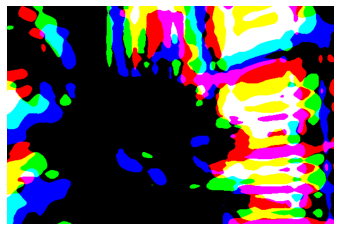

In [34]:
# show processed image
processed_by_net_image = net.forward(target)
processed_and_reshaped_image = transformation_conv_img(processed_by_net_image)
plt.imshow(img_convert(processed_and_reshaped_image))
plt.axis('off')
plt.show()